# Import Packages

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16

In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.metrics import Recall, Precision

import glob
from pathlib import Path

In [5]:
%matplotlib inline

# Introduction

Clinical Dementia Ratings (CDR) are provided in the dataset with the following attributions:

    0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD

For the purpose of analysis, all patients with a CDR of 0 are giving a diagnosis of 0, denoting cognitively healthy. CDR ratings above 0 are converted to 1, for an AD diagnosis, and binary classification.

diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' }


# Load Diagnosis

In [68]:
user_path = Path('/Users/mkv/code/mkvph0ch/memobrain/')
gcp_path = 'gs://memobrain/raw_data/'

oas1_dia_file = user_path.joinpath('raw_data/OASIS1/oasis_cross-sectional.csv')

In [59]:
# load to pandas df, show head
oas1_dia_df = pd.read_csv(oas1_dia_file )
oas1_dia_df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [60]:
# make copy and extract only relevant columns
oas1_dia = oas1_dia_df.copy()[['ID', 'CDR']]
oas1_dia

,ID,CDR
0,OAS1_0001_MR1,0.0
1,OAS1_0002_MR1,0.0
2,OAS1_0003_MR1,0.5
3,OAS1_0004_MR1,NaN
4,OAS1_0005_MR1,NaN
...,...,...
431,OAS1_0285_MR2,NaN
432,OAS1_0353_MR2,NaN
433,OAS1_0368_MR2,NaN
434,OAS1_0379_MR2,NaN


In [61]:
# drop all missing values
oas1_dia.dropna(inplace=True)

In [62]:
# check the shape
oas1_dia.shape

(235, 2)

In [63]:
# check the values
oas1_dia['CDR'].value_counts()

0.0    135
0.5     70
1.0     28
2.0      2
Name: CDR, dtype: int64

In [64]:
def binary_target(value):
    '''convert all dementia to 1, leave no dementia to 0'''
    if value != 0:
        return 1
    else:
        return value

In [65]:
oas1_dia['CDR'] = oas1_dia['CDR'].apply(lambda x: binary_target(x))

In [66]:
oas1_dia['CDR'].value_counts()

0.0    135
1.0    100
Name: CDR, dtype: int64

In [486]:
dummy_noAD = 135/(135+100)
dummy_noAD

0.574468085106383

In [487]:
dummy_AD = 100/(135+100)
dummy_AD

0.425531914893617

In [488]:
(dummy_noAD**2) + 2*(dummy_noAD*dummy_AD) + (dummy_AD**2)

1.0

In [67]:
# check if binary_target function worked correct
assert(oas1_dia['CDR'].value_counts().values[1] == oas1_dia['CDR'].value_counts().values[1:].sum())

In [ ]:
oas

# Load MRI Images

In [72]:
# find all Data, e.g. in OASIS 1
local_path_oas1 = user_path.joinpath('raw_data/OASIS1/OAS1_RAW/')
local_path_oas1

PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW')

In [94]:
def find_files_specific(file_ext, list_dirs, cpath):
    '''find all processed images with {file_ext} in {cpath} which are in list_dirs
    file_ext: str
    cpath: str
    '''
    # join all path
    all_paths = []
    for item in list(oas1_dia['ID']):
        all_paths.append(local_path_oas1.joinpath(item).joinpath('PROCESSED/MPRAGE/T88_111/'))
    
    all_jpgs = []
    
    for file_path in all_paths:
        for jpg_path in file_path.glob(f"*_t88_gfc_*.{file_ext}"):
            all_jpgs.append(jpg_path)

    return all_jpgs

In [85]:
# load all jpgs in OASIS1
oasis1_jpg_paths = find_files('jpg', cpath=str(local_path_oas1))
len(oasis1_jpg_paths)

4304

In [95]:
# load specific jpgs in OASIS1
oasis1_sp_jpg_paths = find_files_specific('jpg', list_dirs=list(oas1_dia['ID']), cpath=str(local_path_oas1))
len(oasis1_sp_jpg_paths)

705

In [131]:
oasis1_sp_jpg_paths[0:3]

[PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_sag_95.jpg'),
 PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_cor_110.jpg'),
 PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_tra_90.jpg')]

In [238]:
oasis1_sp_jpg_paths[0]#.joinpath('/code/data/')

PosixPath('/Users/mkv/code/mkvph0ch/memobrain/raw_data/OASIS1/OAS1_RAW/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_sag_95.jpg')

# Plot Images

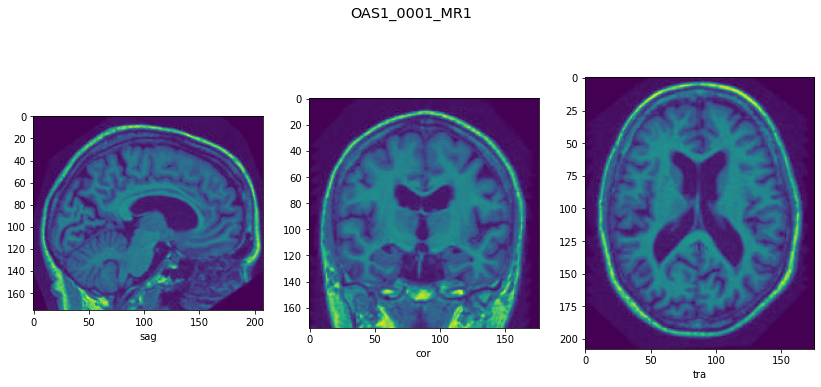

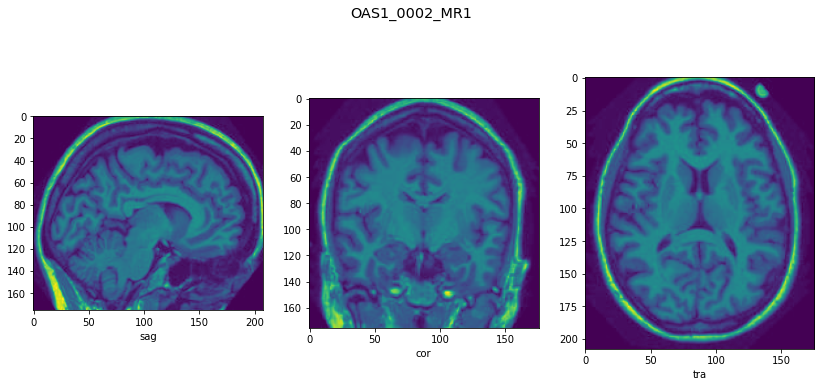

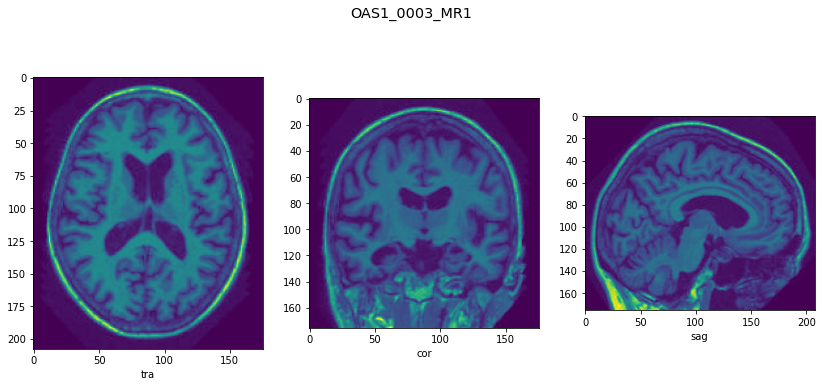

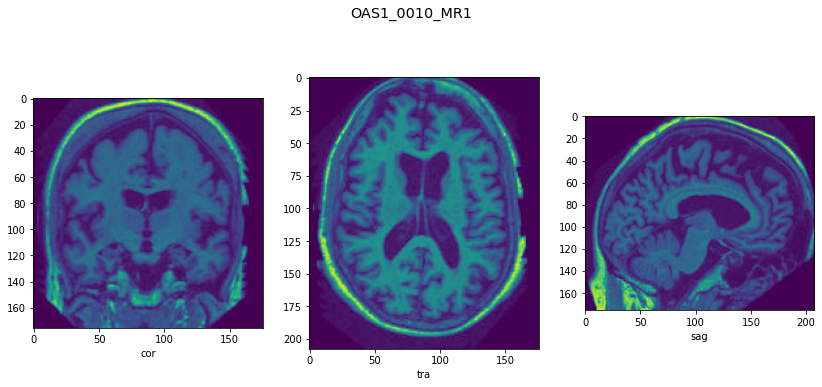

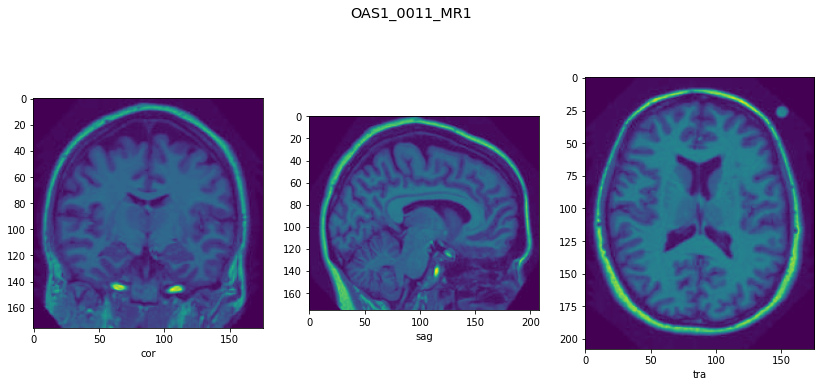

In [139]:
for i in range(0, 15, 3):
    img_01 = plt.imread(oasis1_sp_jpg_paths[i])
    img_02 = plt.imread(oasis1_sp_jpg_paths[i+1])
    img_03 = plt.imread(oasis1_sp_jpg_paths[i+2])

    fig, axs = plt.subplots(1,3, figsize=(14, 6))
    fig.suptitle(str(oasis1_sp_jpg_paths[i].parent).split('/')[-4], fontsize='x-large')
    
    axs[0].imshow(img_01)
    axs[0].set_xlabel(oasis1_sp_jpg_paths[i].stem.split('_')[-2])
    
    axs[1].imshow(img_02)
    axs[1].set_xlabel(oasis1_sp_jpg_paths[i+1].stem.split('_')[-2])
    
    axs[2].imshow(img_03)
    axs[2].set_xlabel(oasis1_sp_jpg_paths[i+2].stem.split('_')[-2])

# Preprocess MRI Images

In [5]:
# grayscale
# reshape
# test_train_split

In [402]:
oasis1_dict = {
    'Folder': [],
    'Dataset': [],
    'Subject_ID': [],
    'MR': [],
    'n': [],
    'orient': [],
    'image_arr': [],
    'CDR': []
}

In [403]:
# iterate over all jpg paths and append to dictionary

for i in range(0, len(oasis1_sp_jpg_paths)):
    # data from csv
    oasis1_dict['Folder'].append(oasis1_sp_jpg_paths[i].stem.split('_mpr')[0])
    oasis1_dict['Dataset'].append(oasis1_sp_jpg_paths[i].stem.split('_')[0])
    oasis1_dict['Subject_ID'].append(oasis1_sp_jpg_paths[i].stem.split('_')[1])
    oasis1_dict['MR'].append(oasis1_sp_jpg_paths[i].stem.split('_')[2][-1])
    oasis1_dict['n'].append(oasis1_sp_jpg_paths[i].stem.split('_')[4][-1])
    oasis1_dict['orient'].append(oasis1_sp_jpg_paths[i].stem.split('_')[-2])
    
    # images
    img = plt.imread(oasis1_sp_jpg_paths[i])
    img = img.reshape(img.shape[0], img.shape[1], 1) # array -> tensor
    oasis1_dict['image_arr'].append(img)

In [404]:
for item in oasis1_dict['Folder']:
    cdr = int(oas1_dia[oas1_dia['ID'] == item]['CDR'].values[0])
    oasis1_dict['CDR'].append(cdr)

In [405]:
oasis1_df = pd.DataFrame.from_dict(oasis1_dict)
oasis1_df.head(20)

,Folder,Dataset,Subject_ID,MR,n,orient,image_arr,CDR
0,OAS1_0001_MR1,OAS1,0001,1,4,sag,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
1,OAS1_0001_MR1,OAS1,0001,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
2,OAS1_0001_MR1,OAS1,0001,1,4,tra,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
3,OAS1_0002_MR1,OAS1,0002,1,4,sag,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
4,OAS1_0002_MR1,OAS1,0002,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
5,OAS1_0002_MR1,OAS1,0002,1,4,tra,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
6,OAS1_0003_MR1,OAS1,0003,1,4,tra,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
7,OAS1_0003_MR1,OAS1,0003,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
8,OAS1_0003_MR1,OAS1,0003,1,4,sag,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1
9,OAS1_0010_MR1,OAS1,0010,1,4,cor,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0


In [497]:
oasis1_df.to_pickle(user_path.joinpath('raw_data/OASIS1/oasis1_df.pkl'))

In [498]:
oasis1_sag = oasis1_df[oasis1_df['orient'] == 'sag'].reset_index(drop=True)
oasis1_sag.to_pickle(user_path.joinpath('raw_data/OASIS1/oasis1_sag.pkl'))

In [499]:
oasis1_tra = oasis1_df[oasis1_df['orient'] == 'tra'].reset_index(drop=True)
oasis1_tra.to_csv(user_path.joinpath('raw_data/OASIS1/oasis1_tra.pkl'))

In [500]:
oasis1_cor = oasis1_df[oasis1_df['orient'] == 'cor'].reset_index(drop=True)
oasis1_cor.to_csv(user_path.joinpath('raw_data/OASIS1/oasis1_cor.pkl'))

## Train Test split

In [422]:
def convert2tensor(array):
    return np.array([image for image in array])

In [505]:
X_cor = convert2tensor(oasis1_cor['image_arr'].values)
y_cor = oasis1_cor['CDR'].values

In [506]:
X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(X_cor, y_cor, test_size=.3, random_state=42)

In [507]:
X_sag = convert2tensor(oasis1_sag['image_arr'].values)
y_sag = oasis1_sag['CDR'].values

In [508]:
X_train_sag, X_test_sag, y_train_sag, y_test_sag = train_test_split(X_sag, y_sag, test_size=.3, random_state=42)

In [509]:
X_tra = convert2tensor(oasis1_tra['image_arr'].values)
y_tra = oasis1_tra['CDR'].values

In [510]:
X_train_tra, X_test_tra, y_train_tra, y_test_tra = train_test_split(X_tra, y_tra, test_size=.3, random_state=42)

# Convolutional neural network

In [515]:
input_shape_cor = (176, 176, 1)
input_shape_sag = (176, 208, 1)
input_shape_tra = (208, 176, 1)

def create_model(input_sh):
    model = Sequential()
    model.add(Conv2D(100, kernel_size=(3, 3), strides=(10,10),
                     activation='sigmoid', padding ='same',
                     input_shape=input_sh))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(50, (3, 3), activation='sigmoid', strides=(5,5), padding ='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(25, kernel_size=(3,3), activation='sigmoid', strides = (1,1), padding ='same'))
    model.add(MaxPooling2D(pool_size=(1, 1), padding='valid'))
    model.add(Flatten())
    #model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 'Recall', 'Precision'])
    
    return model

In [516]:
basic_cnn_cor = create_model(input_shape_cor)

basic_cnn_sag = create_model(input_shape_sag)

basic_cnn_tra = create_model(input_shape_tra)

In [517]:
es = EarlyStopping(monitor='loss', patience=10)

history_cor = basic_cnn_cor.fit(X_train_cor, y_train_cor, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [518]:
basic_cnn_cor.evaluate(X_test_cor, y_test_cor)

3/3 [==============================] - 0s 2ms/step - loss: 1.2379 - accuracy: 0.7183 - recall: 0.5862 - precision: 0.6800


[1.2379341125488281,
 0.7183098793029785,
 0.5862069129943848,
 0.6800000071525574]

In [519]:
es = EarlyStopping(monitor='loss', patience=10)

history_sag = basic_cnn_sag.fit(X_train_sag, y_train_sag, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [520]:
basic_cnn_sag.evaluate(X_test_sag, y_test_sag)

3/3 [==============================] - 0s 3ms/step - loss: 1.3646 - accuracy: 0.7042 - recall: 0.6552 - precision: 0.6333


[1.3646284341812134,
 0.7042253613471985,
 0.6551724076271057,
 0.6333333253860474]

In [521]:
es = EarlyStopping(monitor='loss', patience=10)

history_tra = basic_cnn_tra.fit(X_train_tra, y_train_tra, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [522]:
basic_cnn_tra.evaluate(X_test_tra, y_test_tra)

3/3 [==============================] - 0s 13ms/step - loss: 0.6780 - accuracy: 0.5915 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.6780323386192322, 0.591549277305603, 0.0, 0.0]

# OASIS 2

In [523]:
oas2_df_file = user_path.joinpath('raw_data/OASIS2/oas2_df.pkl')
oas2_df = pd.read_pickle(oas2_df_file)
oas2_df.head()

,full_path,image,plane,subject_id,session,file_names,CDR
0,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[59.92892578718232], [199.1923654299807], [1...",sag,OAS2_0001,MR1,mpr-1.nifti.img,0
1,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[71.67888621794873], [256.4102712060012], [1...",tra,OAS2_0001,MR1,mpr-1.nifti.img,0
2,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[73.87677356656945], [162.90141406094403], [...",cor,OAS2_0001,MR1,mpr-1.nifti.img,0
3,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[63.69345293138525], [134.62243886318572], [...",sag,OAS2_0001,MR1,mpr-2.nifti.img,0
4,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,"[[[77.22216097023147], [77.22216097023147], [1...",tra,OAS2_0001,MR1,mpr-2.nifti.img,0


In [524]:
# seperate by plane
oas2_sag = oas2_df[oas2_df['plane'] == 'sag']
oas2_cor = oas2_df[oas2_df['plane'] == 'cor']
oas2_tra = oas2_df[oas2_df['plane'] == 'tra']

In [532]:
# saggital
X_oas2_sag = np.array([x for x in oas2_sag.image])
y_oas2_sag = oas2_sag['CDR'].values

X_train_oas2_sag, X_test_oas2_sag, y_train_oas2_sag, y_test_oas2_sag =\
        train_test_split(X_oas2_sag, y_oas2_sag, test_size=.3, random_state=42)

# tra
X_oas2_tra = np.array([x for x in oas2_cor.image])
y_oas2_tra = oas2_tra['CDR'].values

X_train_oas2_tra, X_test_oas2_tra, y_train_oas2_tra, y_test_oas2_tra =\
        train_test_split(X_oas2_tra, y_oas2_tra, test_size=.3, random_state=42)

# cor
X_oas2_cor = np.array([x for x in oas2_tra.image])
y_oas2_cor = oas2_cor['CDR'].values

X_train_oas2_cor, X_test_oas2_cor, y_train_oas2_cor, y_test_oas2_cor =\
        train_test_split(X_oas2_cor, y_oas2_cor, test_size=.3, random_state=42)

In [538]:
X_train_oas2_sag[0].shape

(256, 256, 1)

In [539]:
X_train_oas2_tra[0].shape

(256, 128, 1)

In [540]:
X_train_oas2_cor[0].shape

(256, 128, 1)

In [541]:
basic_cnn_cor = create_model(X_train_oas2_cor[0].shape)

basic_cnn_sag = create_model(X_train_oas2_sag[0].shape)

basic_cnn_tra = create_model(X_train_oas2_tra[0].shape)

In [542]:
es = EarlyStopping(monitor='loss', patience=10)

history_cor = basic_cnn_cor.fit(X_train_oas2_cor, y_train_oas2_cor, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [543]:
basic_cnn_cor.evaluate(X_test_oas2_cor, y_test_oas2_cor)

13/13 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5718 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.6814547777175903, 0.5717761516571045, 0.0, 0.0]

In [544]:
es = EarlyStopping(monitor='loss', patience=10)

history_sag = basic_cnn_sag.fit(X_train_oas2_sag, y_train_oas2_sag, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [545]:
basic_cnn_sag.evaluate(X_test_oas2_sag, y_test_oas2_sag)

13/13 [==============================] - 0s 4ms/step - loss: 2.1150 - accuracy: 0.5937 - recall: 0.5114 - precision: 0.5263


[2.1150410175323486,
 0.5936739444732666,
 0.5113636255264282,
 0.5263158082962036]

In [546]:
es = EarlyStopping(monitor='loss', patience=10)

history_sag = basic_cnn_tra.fit(X_train_oas2_tra, y_train_oas2_tra, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [547]:
basic_cnn_tra.evaluate(X_test_oas2_tra, y_test_oas2_tra)

13/13 [==============================] - 0s 2ms/step - loss: 0.6743 - accuracy: 0.5839 - recall: 0.6989 - precision: 0.5104


[0.674309253692627, 0.5839415788650513, 0.6988636255264282, 0.5103734731674194]

## Concatinated Images

In [549]:
# import
oas2_concat_file = user_path.joinpath('raw_data/OASIS2/oas2_concat.pkl')
oas2_concat = pd.read_pickle(oas2_concat_file)
oas2_concat.head()

,full_path,subject_id,session,file_names,CDR,concated
0,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,OAS2_0001,MR1,mpr-1.nifti.img,0,"[[[59.92892578718232], [199.1923654299807], [1..."
1,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,OAS2_0001,MR1,mpr-2.nifti.img,0,"[[[63.69345293138525], [134.62243886318572], [..."
2,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR1/RAW/...,OAS2_0001,MR1,mpr-3.nifti.img,0,"[[[200.25682718365644], [59.54695643622773], [..."
3,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR2/RAW/...,OAS2_0001,MR2,mpr-1.nifti.img,0,"[[[140.0265449319469], [66.37793075925373], [6..."
4,../raw_data/OASIS2/OAS2_RAW/OAS2_0001_MR2/RAW/...,OAS2_0001,MR2,mpr-2.nifti.img,0,"[[[199.62401708571983], [60.976264764876305], ..."


In [555]:
X = np.array([x for x in oas2_concat.concated]) #np.array(oas2_concat['concated'].values)
y = oas2_concat['CDR'].values

In [557]:
X_train_concat, X_test_concat, y_train_concat, y_test_concat = train_test_split(X, y, test_size=0.3, random_state=42)

In [558]:
X_train_concat[0].shape

(256, 572, 1)

In [559]:
base_cnn_concat = create_model(X_train_concat[0].shape)

In [561]:
es = EarlyStopping(monitor='loss', patience=10)

history_oas2_concat = base_cnn_concat.fit(X_train_concat, y_train_concat, 
                                epochs=500,
                                verbose=0,
                                batch_size=32,
                                callbacks=[es])

In [562]:
base_cnn_concat.evaluate(X_test_concat, y_test_concat)

13/13 [==============================] - 1s 13ms/step - loss: 1.8447 - accuracy: 0.6983 - recall: 0.6591 - precision: 0.6444


[1.844679355621338, 0.698296844959259, 0.6590909361839294, 0.644444465637207]

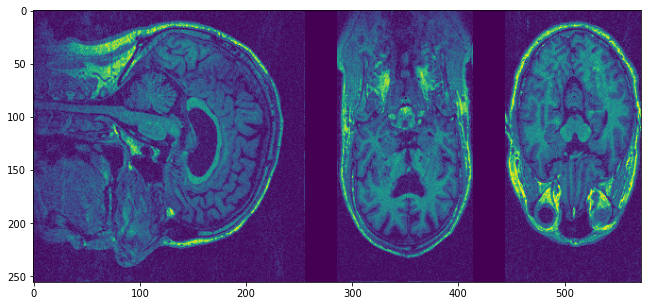

In [564]:
plt.figure(figsize=(12,5))
plt.imshow(X_train_concat[0])